<a href="https://colab.research.google.com/github/yubin0727/NLP_Practice/blob/main/Lap_2_Diving_Deep_into_Supervised_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

## Defining the Model

In [ ]:
class Perceptron(nn.Module):
    """ A Perceptron is one Linear layer """

    def __init__(self, input_dim):
        """
        Args:
            input_dim (int): size of the input features
        """
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x_in):
        """The forward pass of the MLP

        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
        Returns:
            the resulting tensor. tensor.shape should be (batch, 1)
        """
        return torch.sigmoid(self.fc1(x_in))

# Activation function
## Sigmoid
is one of the earliest used activation functions in neural network history.
takes any real value and squashes it into the range between 0 and 1. 
Mathematically, the sigmoid function is expressed as follows:

$𝑓(𝑥)=\frac{1}{1+e^{-𝑥}} $

PyTorch implements the sigmoid as `torch.sigmoid()`



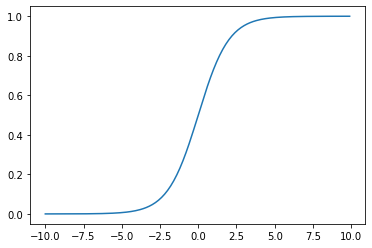

In [ ]:
import torch
import matplotlib.pyplot as plt

x = torch.arange(-10., 10., 0.1)
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.numpy())
plt.show()

## Relu or LeakyRelu
rectified linear unit (ReLU) is doing is clipping the negative
values to zero or gives negative slope (LeakyReLu).


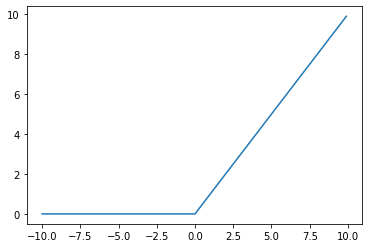

In [ ]:
relu = torch.nn.ReLU()
x = torch.arange(-10., 10., 0.1)
y = relu(x)
plt.plot(x.numpy(), y.numpy())
plt.show()

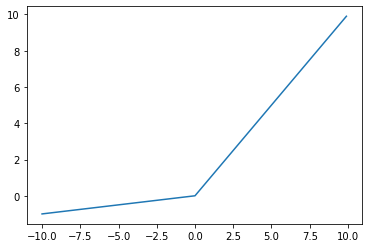

In [ ]:
leakyRelu = torch.nn.LeakyReLU(negative_slope=0.1)
x = torch.arange(-10., 10., 0.1)
y = leakyRelu(x)
plt.plot(x.numpy(), y.numpy())
plt.show()

## SoftMax
Gives us a discrete (categorical) probability distribution over 𝑘 possible classes
* final layer of a network for multi-class classification
* Torch.nn.Softmax()

In [ ]:
softmax = torch.nn.Softmax(dim=1)
x_input = torch.randn(1, 3)
y_output = softmax(x_input)
print(x_input)
print(y_output)
print(torch.sum(y_output, dim=1))

tensor([[-0.5245,  0.4956, -0.3566]])
tensor([[0.2018, 0.5596, 0.2387]])
tensor([1.0000])


# Loss Funtions
## MSE Loss
`torch.nn.Loss` is simply the average of the squares of the difference between the predicted and target values.


In [ ]:
mse_loss = torch.nn.MSELoss()
outputs = torch.randn(3, 5, requires_grad=True)
targets = torch.randn(3, 5)
loss = mse_loss(outputs, targets)
print(loss)

tensor(2.3326, grad_fn=<MseLossBackward0>)


## Binary Cross Entropy
Creates a criterion that measures the Binary Cross Entropy between the target and the input probabilities.

In [ ]:
bce_loss = nn.BCELoss()
sigmoid = nn.Sigmoid()
probabilities = sigmoid(torch.randn(4, 1, requires_grad=True))

targets = torch.tensor([1, 0, 1, 0], dtype=torch.float32).view(4, 1)

loss = bce_loss(probabilities, targets)
print(probabilities)
print(targets)
print(loss)

tensor([[0.3239],
        [0.4213],
        [0.4499],
        [0.6773]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [0.],
        [1.],
        [0.]])
tensor(0.9010, grad_fn=<BinaryCrossEntropyBackward0>)


# Training NN with Toy Example

## Get Data Function

In [ ]:
LEFT_CENTER = (3, 3)
RIGHT_CENTER = (3, -2)

In [ ]:
def get_toy_data(batch_size, left_center=LEFT_CENTER, right_center=RIGHT_CENTER):
    x_data = []
    y_targets = np.zeros(batch_size)
    for batch_i in range(batch_size):
        if np.random.random() > 0.5:
            x_data.append(np.random.normal(loc=left_center))
        else:
            x_data.append(np.random.normal(loc=right_center))
            y_targets[batch_i] = 1
    return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.float32)

## Visualizing Results Function

In [ ]:
def visualize_results(perceptron, x_data, y_truth, n_samples=1000, ax=None, epoch=None, 
                      title='', levels=[0.3, 0.4, 0.5], linestyles=['--', '-', '--']):
    y_pred = perceptron(x_data)
    y_pred = (y_pred > 0.5).long().data.numpy().astype(np.int32)

    x_data = x_data.data.numpy()
    y_truth = y_truth.data.numpy().astype(np.int32)

    n_classes = 2

    all_x = [[] for _ in range(n_classes)]
    all_colors = [[] for _ in range(n_classes)]
    
    colors = ['black', 'white']
    markers = ['o', '*']
    
    for x_i, y_pred_i, y_true_i in zip(x_data, y_pred, y_truth):
        all_x[y_true_i].append(x_i)
        if y_pred_i == y_true_i:
            all_colors[y_true_i].append("white")
        else:
            all_colors[y_true_i].append("black")
        #all_colors[y_true_i].append(colors[y_pred_i])

    all_x = [np.stack(x_list) for x_list in all_x]

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10,10))
        
    for x_list, color_list, marker in zip(all_x, all_colors, markers):
        ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor="black", marker=marker, facecolor=color_list, s=300)
    
        
    xlim = (min([x_list[:,0].min() for x_list in all_x]), 
            max([x_list[:,0].max() for x_list in all_x]))
            
    ylim = (min([x_list[:,1].min() for x_list in all_x]), 
            max([x_list[:,1].max() for x_list in all_x]))
            
    # hyperplane
    
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    Z = perceptron(torch.tensor(xy, dtype=torch.float32)).detach().numpy().reshape(XX.shape)
    ax.contour(XX, YY, Z, colors='k', levels=levels, linestyles=linestyles)    
    
    plt.suptitle(title)
    
    if epoch is not None:
        plt.text(xlim[0], ylim[1], "Epoch = {}".format(str(epoch)))

## Initial Data Plot

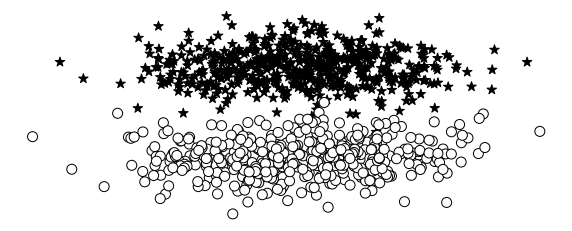

In [ ]:
seed = 1337

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

x_data, y_truth = get_toy_data(batch_size=1000)

x_data = x_data.data.numpy()
y_truth = y_truth.data.numpy()

left_x = []
right_x = []
left_colors = []
right_colors =  []

for x_i, y_true_i in zip(x_data, y_truth):
    color = 'black'

    if y_true_i == 0:
        left_x.append(x_i)
        left_colors.append(color)

    else:
        right_x.append(x_i)
        right_colors.append(color)

left_x = np.stack(left_x)
right_x = np.stack(right_x)

_, ax = plt.subplots(1, 1, figsize=(10,4))

ax.scatter(left_x[:, 0], left_x[:, 1], color=left_colors, marker='*', s=100)
ax.scatter(right_x[:, 0], right_x[:, 1], facecolor='white', edgecolor=right_colors, marker='o', s=100)

plt.axis('off');

## The Training + intermittent data plots

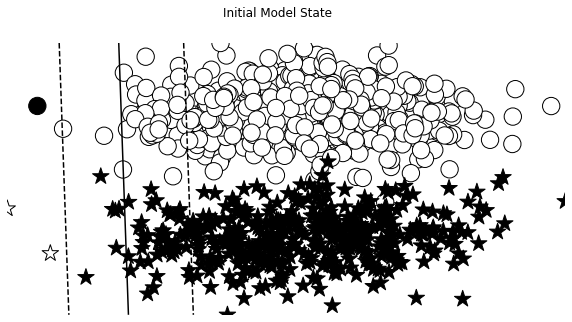

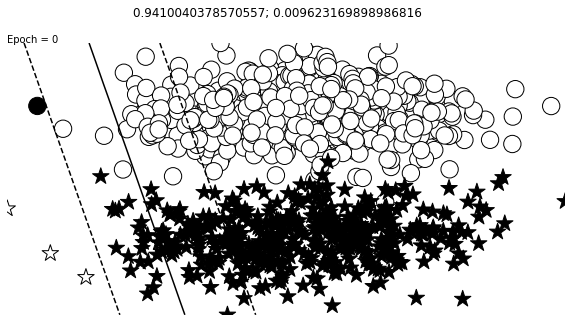

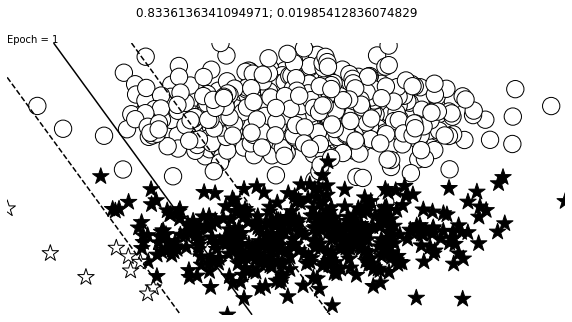

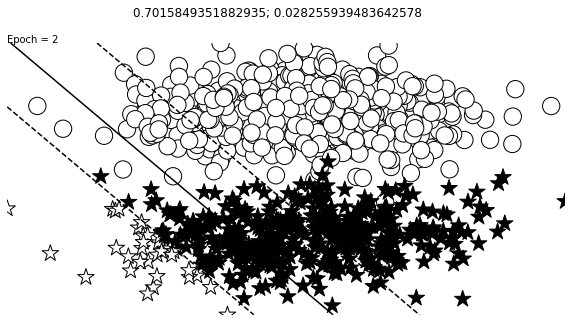

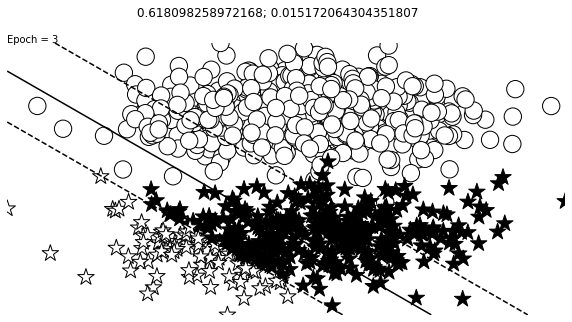

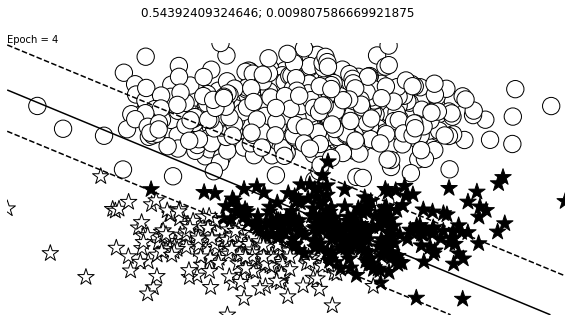

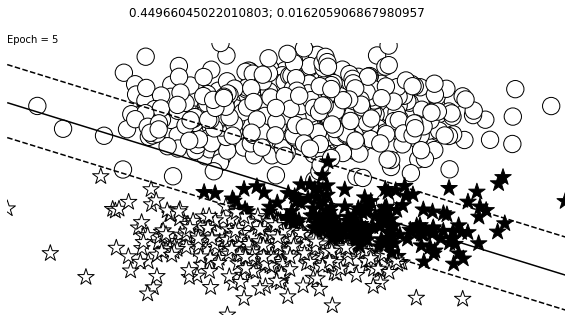

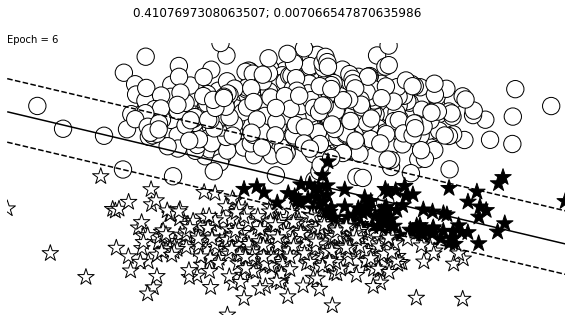

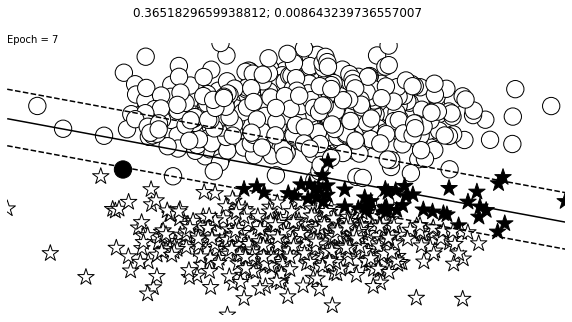

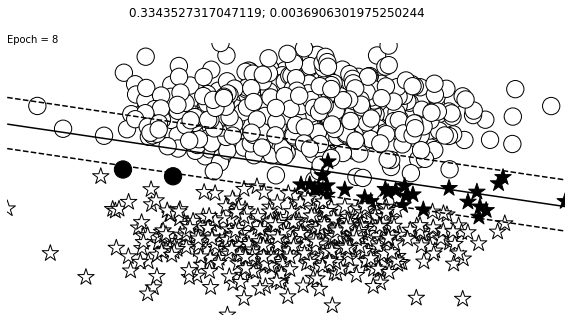

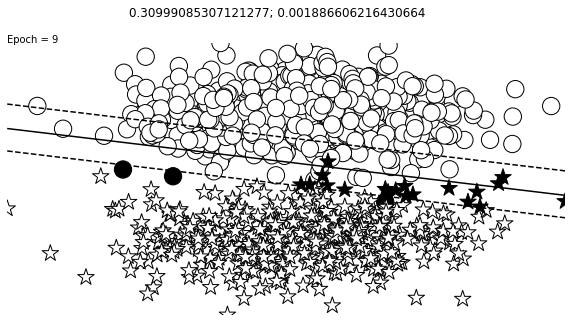

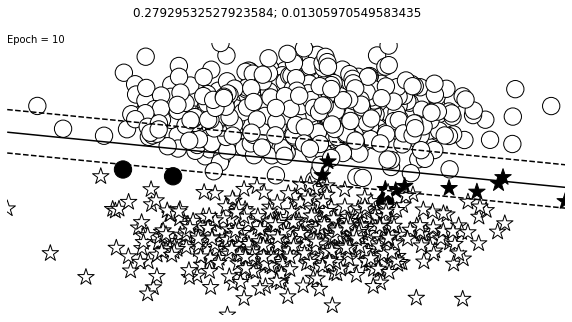

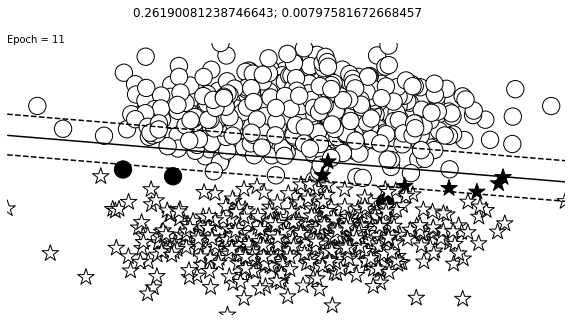

In [ ]:
lr = 0.01
input_dim = 2

batch_size = 1000
n_epochs = 12
n_batches = 5

seed = 1337

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

perceptron = Perceptron(input_dim=input_dim)  # define the model
optimizer = optim.Adam(params=perceptron.parameters(), lr=lr)  # choose optimizer
bce_loss = nn.BCELoss()  # choose loss function

losses = []

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(perceptron, x_data_static, y_truth_static, ax=ax, title='Initial Model State')
plt.axis('off')
#plt.savefig('initial.png')

change = 1.0
last = 10.0
epsilon = 1e-3
epoch = 0
#while change > epsilon or epoch < n_epochs or last > 0.3:
for epoch in range(n_epochs):
    for _ in range(n_batches):
        # Step 0: Get the data
        x_data, y_target = get_toy_data(batch_size)

        # Step 1: Clear the gradients
        perceptron.zero_grad()
        
        # Step 2: Compute the forward pass of the model
        y_pred = perceptron(x_data).squeeze()
        
        # Step 3: Compute the loss value that we wish to optimize
        loss = bce_loss(y_pred, y_target)
        
        # Step 4: Propagate the loss signal backward
        loss.backward()
        
        # Step 5: Trigger the optimizer to perform one update
        optimizer.step()
                
        loss_value = loss.item()
        losses.append(loss_value)

        change = abs(last - loss_value)
        last = loss_value
               
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    visualize_results(perceptron, x_data_static, y_truth_static, ax=ax, epoch=epoch, 
                      title=f"{loss_value}; {change}")
    plt.axis('off')
    epoch += 1

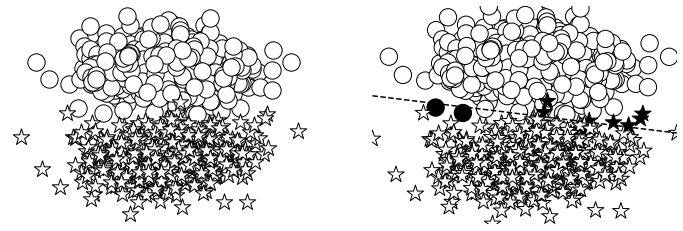

In [ ]:
_, axes = plt.subplots(1,2,figsize=(12,4))


axes[0].scatter(left_x[:, 0], left_x[:, 1], facecolor='white',edgecolor='black', marker='o', s=300)
axes[0].scatter(right_x[:, 0], right_x[:, 1], facecolor='white', edgecolor='black', marker='*', s=300)
axes[0].axis('off');
visualize_results(perceptron, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[1])
axes[1].axis('off');